In [51]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy, os
from cartopy import feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy import crs as ccrs
import datetime as dt
import numpy as np
from cmocean import cm
import cmocean
import seaborn as sns
import matplotlib.colors as colors

# from geopy.distance import vincenty
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import scipy.ndimage as ndimage

# import salem
# import geopandas as gpd

In [53]:

MWII = [36.60368,  -121.889275]
SCW  = [36.9603, -122.0204]

TomalesBayBuoy =  [38.1897, -122 - 55.718/60]
TomalesBayMouth = [38 + 13.849/60, -122 - 58.744/60]
TomalesBayInverness = [38 + 7.079/60, -122 - 52.018/60]
BMLBuoy = [38 + 18.756/60, -123 - 04.953/60]
HorseshoeCove = [38.315612, -123.070985]


TrinidadPier = [41.055, -124.147]
HumboldtBay = [40.7772, -124.1963]
SouthBayStation = [40.72343, -124.2234]

ml_sites = [MWII]
sc_sites = [SCW]
b_sites = [TomalesBayBuoy, TomalesBayInverness, TomalesBayMouth, BMLBuoy, HorseshoeCove]
h_sites = [TrinidadPier, HumboldtBay, SouthBayStation]

In [86]:
# Mapping helper function
def make_map(projection=ccrs.PlateCarree(),extent=(-125.5,-121,36,42)):
    fig, ax = plt.subplots(
        subplot_kw={'projection': projection},
        figsize=(12, 12)
    )
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.xlabel_style = {'size': 22}
    gl.ylabel_style = {'size': 22}
    # gl.ylocator = mticker.FixedLocator(range(36,48,1))
    # gl.xlocator = mticker.FixedLocator(range(-128,-100,1))
    # gl.xformatter = LONGITUDE_FORMATTER
    # gl.yformatter = LATITUDE_FORMATTER
    
    land_10m  = cfeature.NaturalEarthFeature(category='physical', name='land',
                            scale='10m', facecolor="#bb8e5b", edgecolor='k')
    ax.add_feature(land_10m,zorder=20)
    ocean_50m  = cfeature.NaturalEarthFeature(category='physical', name='ocean',
                            scale='50m', facecolor=cfeature.COLORS['water'])
#     ax.add_feature(ocean_50m,zorder=0)
    return fig, ax

def plot_bathy(ax):
    ''' Plot the course bathymetery from natural Earth'''
    cmap = plt.get_cmap('Blues')
    norm = colors.Normalize(0, 5000)
    for letter, level in [('L', 0,),('K', 200),('J', 1000),  ('I', 2000),  ('H', 3000),  ('G', 4000)]:
        bathym = cfeature.NaturalEarthFeature(name='bathymetry_{}_{}'.format(letter, level),
                                     scale='10m', category='physical', zorder=0)
        ax.add_feature(bathym,facecolor=cmap(norm(level)), edgecolor='face')


def scatter_site(ax, site:list, color='k'):
    """ Helper function for formatting shore station """
    ax.scatter(site[1],site[0],s=200,zorder=80,c=color,edgecolor='.75', linewidth=2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

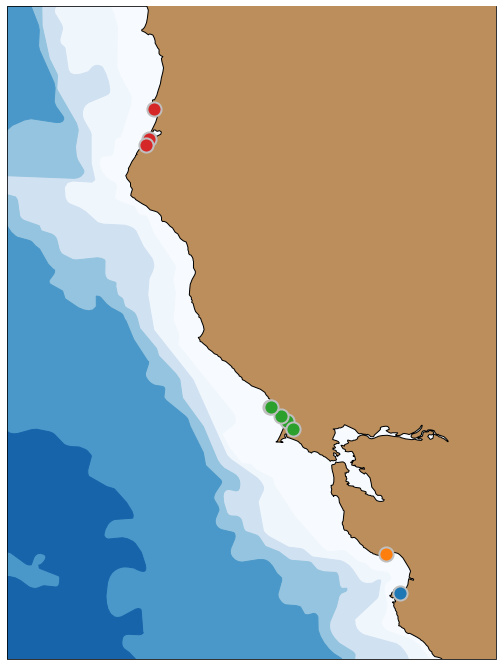

In [88]:
fig,ax = make_map()
plot_bathy(ax)

cmap = sns.color_palette(n_colors=4)

for s in ml_sites:
    scatter_site(ax,s,cmap[0])

for s in sc_sites:
    scatter_site(ax,s,cmap[1])

for s in b_sites:
    scatter_site(ax,s,cmap[2])

for s in h_sites:
    scatter_site(ax,s,cmap[3])
plt.savefig('full_map.png',dpi=300, bbox_inches='tight', pad_inches=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


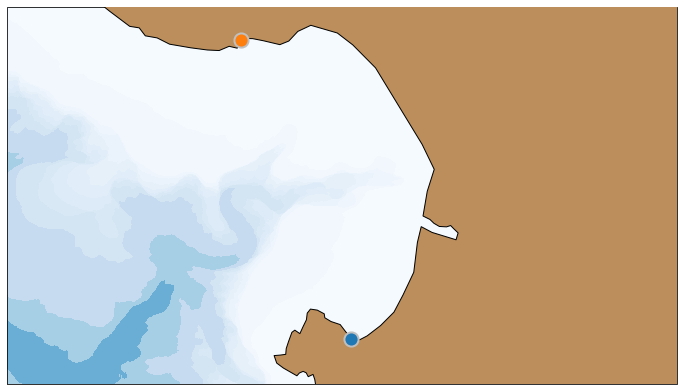

In [142]:
fig,ax = make_map()
# plot_bathy(ax)

cmap = sns.color_palette(n_colors=4)

for s in ml_sites:
    scatter_site(ax,s,cmap[0])

for s in sc_sites:
    scatter_site(ax,s,cmap[1])
ax.set_ylim(36.55, 37)
ax.set_xlim(-122.3,-121.5)

ds_bathy = xr.open_dataset("./crm.nc")
elev = ds_bathy['Band1'] * -1
llon, llat = np.meshgrid(ds_bathy['lon'], ds_bathy['lat'])
levels = np.append(np.arange(-10,801,100), np.array((1000,1500,2000,3000,5000)))

CS = ax.contourf(llon,llat,elev,levels,cmap=plt.get_cmap('Blues'))
plt.savefig('mb_map.png',dpi=300, bbox_inches='tight', pad_inches=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

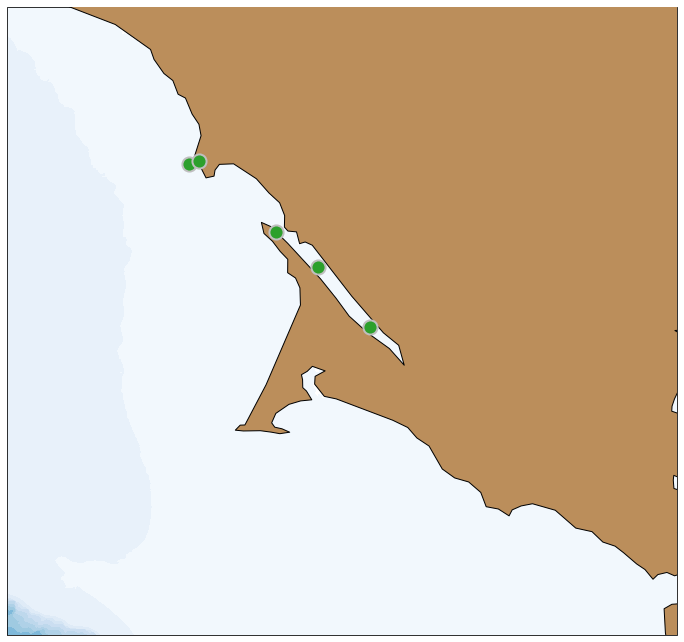

In [144]:
fig,ax = make_map()

cmap = sns.color_palette(n_colors=4)

for s in b_sites:
    scatter_site(ax,s,cmap[2])
ax.set_ylim(37.75, 38.5)
ax.set_xlim(-123.3,-122.5)

ds_bathy = xr.open_dataset("./crm.nc")
elev = ds_bathy['Band1'] * -1
llon, llat = np.meshgrid(ds_bathy['lon'], ds_bathy['lat'])
levels = np.append(np.arange(-10,801,100), np.array((1000,2000)))

CS = ax.contourf(llon,llat,elev,levels,cmap=plt.get_cmap('Blues'))
plt.savefig('bodega_map.png',dpi=300, bbox_inches='tight', pad_inches=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


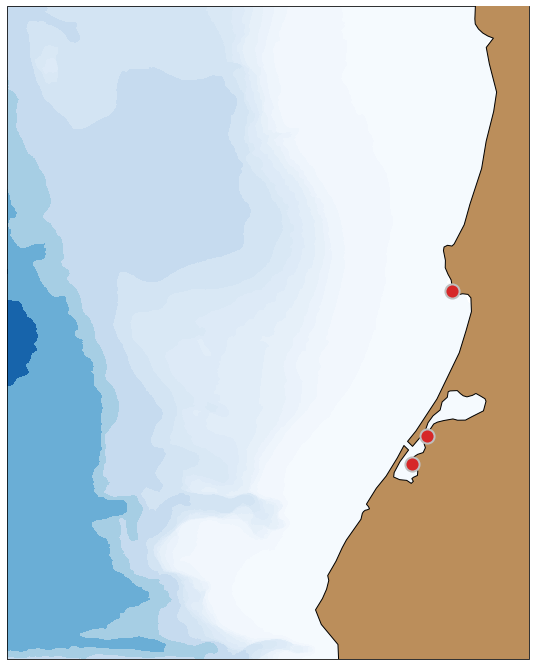

In [147]:
fig,ax = make_map()
# plot_bathy(ax)

cmap = sns.color_palette(n_colors=4)

for s in h_sites:
    scatter_site(ax,s,cmap[3])
ax.set_ylim(40.35, 41.6)
ax.set_xlim(-125,-124)

ds_bathy = xr.open_dataset("./crm-2.nc")
elev = ds_bathy['Band1'] * -1
llon, llat = np.meshgrid(ds_bathy['lon'], ds_bathy['lat'])
levels = np.append(np.arange(-10,801,100), np.array((1000,1500,2000,3000,5000)))

CS = ax.contourf(llon,llat,elev,levels,cmap=plt.get_cmap('Blues'))
plt.savefig('humboldt_map.png',dpi=300, bbox_inches='tight', pad_inches=0)

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.

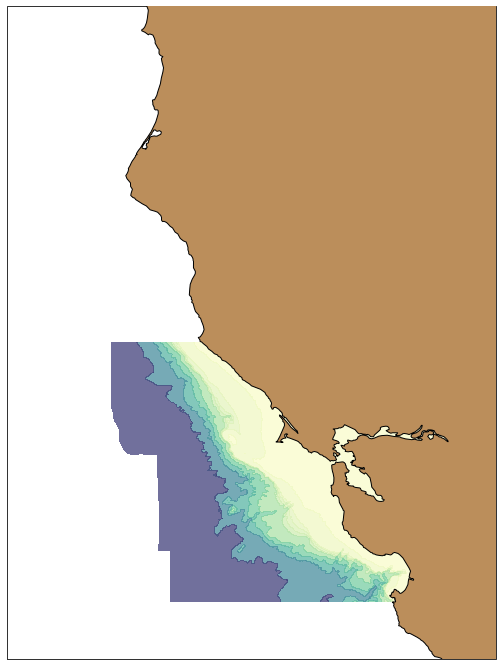

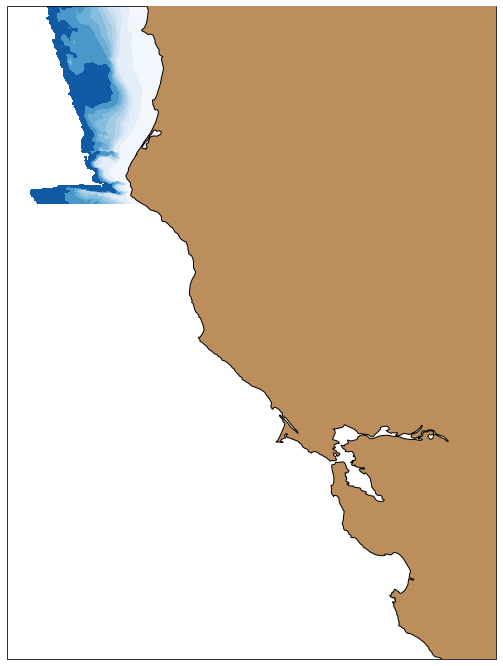

In [134]:
ds_bathy = xr.open_dataset("./crm-2.nc")
elev = ds_bathy['Band1'] * -1
llon, llat = np.meshgrid(ds_bathy['lon'], ds_bathy['lat'])
levels = np.append(np.arange(-10,801,100), np.array((1000,1500)))

fig, ax = make_map()
CS = ax.contourf(llon,llat,elev,levels,cmap=plt.get_cmap('Blues'))